In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán Walmart market và chia train test validate theo tỉ lệ 7:1:2
# Load the dataset
data_url = 'https://raw.githubusercontent.com/minknhom/dataset/main/FB.csv'
df = pd.read_csv(data_url)


df['Date'] = pd.to_datetime(df['Date'])
start_date =  pd.to_datetime('2010-01-01')
end_date =  pd.to_datetime('2022-12-31')
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))
# val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
# val_data = df[train_size+test_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
!pip install pmdarima
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9345.387, Time=5.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9354.500, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9339.616, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9340.096, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9353.748, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9341.401, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9341.416, Time=1.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9343.409, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9339.103, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9340.857, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9340.877, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9339.600, T

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[164.50464363 164.60075403 164.59191763 164.59273005 164.59265536
 164.59266222 164.59266159 164.59266165 164.59266164 164.59266165
 164.59266164 164.59266164 164.59266164 164.59266164 164.59266164
 164.59266164 164.59266164 164.59266164 164.59266164 164.59266164
 164.59266164 164.59266164 164.59266164 164.59266164 164.59266164
 164.59266164 164.59266164 164.59266164 164.59266164 164.59266164]


In [6]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_error

# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Calculate the Mean Absolute Percentage Error (MAPE)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)

# Mean Absolute Error (MAE)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print("Test MAPE:", test_mape)
print("Test MAE:", test_mae)

Testing RMSE: 131.83769621983706
Test MAPE: 40.44486534761207
Test MAE: 121.56822887218937


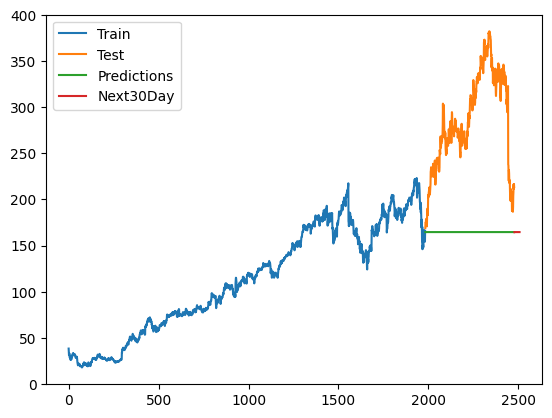

In [7]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
# plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
# plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()